In [1]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your zip file in Google Drive
zip_path = '/content/drive/My Drive/archive (7).zip'

# Path where you want to extract the zip file
extract_path = '/content/drive/My Drive/extracted_images/'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping completed.")


Mounted at /content/drive
Unzipping completed.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [4]:
train_transform=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

In [5]:
import os
data_dir='/content/drive/MyDrive/extracted_images/hymenoptera'
train_dir=os.path.join(data_dir,'train')
val_dir=os.path.join(data_dir,'val')

In [6]:
train_dataset=datasets.ImageFolder(train_dir,transform=train_transform)
val_dataset=datasets.ImageFolder(val_dir,transform=test_transform)

In [7]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(val_dataset,batch_size=32,shuffle=True)

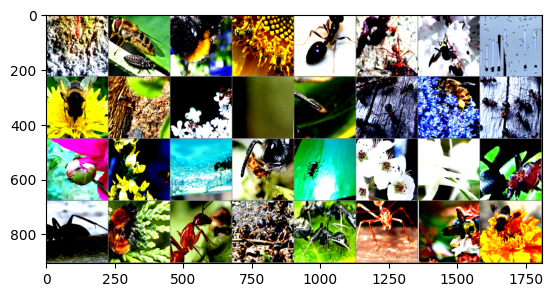

ants  bees  bees  bees  ants  ants  bees  ants  bees  ants  ants  ants  bees  ants  bees  ants  ants  bees  ants  bees  ants  bees  bees  ants  ants  bees  ants  ants  ants  ants  bees  bees 


In [8]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter=iter(train_loader)
images,labels=next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{train_dataset.classes[labels[j]]:5}' for j in range(32))	)

In [22]:
class CustomNet(nn.Module):
  def __init__(self):
    super(CustomNet, self).__init__()
    self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1)
    self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
    self.fc1=nn.Linear(128*28*28,512) # Changed the input size to match the output of convolutional layers
    self.fc2=nn.Linear(512,128)
    self.fc3=nn.Linear(128,2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    x=x.view(-1,128*28*28)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return x

model=CustomNet()

In [23]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [24]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [44]:
num_epochs=10
for epoch in range(num_epochs):
  model.train()
  running_loss=0.0
  total=0
  correct=0
  for images,labels in train_loader:
    images=images.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    _,predicted=torch.max(outputs,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

  train_loss=running_loss/len(train_loader)
  train_accuracy=100*correct/total
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

Epoch [1/10], Loss: 0.2879, Accuracy: 87.70%
Epoch [2/10], Loss: 0.2664, Accuracy: 88.52%
Epoch [3/10], Loss: 0.2650, Accuracy: 88.11%
Epoch [4/10], Loss: 0.3295, Accuracy: 86.07%
Epoch [5/10], Loss: 0.2742, Accuracy: 90.98%
Epoch [6/10], Loss: 0.2478, Accuracy: 90.16%
Epoch [7/10], Loss: 0.2146, Accuracy: 89.75%
Epoch [8/10], Loss: 0.2678, Accuracy: 87.30%
Epoch [9/10], Loss: 0.2389, Accuracy: 90.57%
Epoch [10/10], Loss: 0.2624, Accuracy: 87.70%


In [45]:
model.eval()
val_loss=0.0
val_correct=0
val_total=0
with torch.no_grad():
  for images,labels in test_loader:
    images=images.to(device)
    labels=labels.to(device)
    outputs=model(images)
    loss=criterion(outputs,labels)
    val_loss+=loss.item()
    _,predicted=torch.max(outputs,1)
    val_total+=labels.size(0)
    val_correct+=(labels==predicted).sum().item()

  val_loss=val_loss/len(test_loader)
  val_acc=100*val_correct/val_total
  print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

Validation Loss: 0.5500, Validation Accuracy: 80.39%
